<a href="https://colab.research.google.com/github/cher-ry2003/TEXTGAME/blob/main/bsdbds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import random
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk



In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
uploaded = files.upload()
file_path = next(iter(uploaded))  # Get the filename of the uploaded file
df = pd.read_csv(file_path)
df['prod_des'] = df['prod_des'].fillna('')  # Replace missing descriptions with empty string
df['cust_review'] = df['cust_review'].fillna('')  # Replace missing reviews with empty string

Saving amazon_phone_dataset.csv to amazon_phone_dataset (2).csv


In [ ]:
def add_noise(text):
    """
    Introduce noise by randomly shuffling words in a small percentage of text entries.
    """
    words = text.split()
    if len(words) > 3 and random.random() < 0.1:  # 10% chance to add noise
        random.shuffle(words)
    return ' '.join(words)

df['cust_review'] = df['cust_review'].apply(add_noise)


In [ ]:
def preprocess_text(text):
    """
    Preprocess the text by:
    1. Lowercasing
    2. Removing punctuation and special characters (except numbers)
    3. Removing stopwords
    4. Lemmatization
    """
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['cust_review'] = df['cust_review'].apply(preprocess_text)
df['prod_des'] = df['prod_des'].apply(preprocess_text)

In [ ]:
def get_sentiment(text):
    sentiment_score = TextBlob(text).sentiment.polarity
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['cust_review'].apply(get_sentiment)

In [ ]:
def get_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags

df['pos_tags'] = df['cust_review'].apply(get_pos_tags)

# Add noise to true sentiment labels
true_sentiments = df['sentiment'].tolist()
for i in range(len(true_sentiments)):
    if random.random() < 0.1:  # 10% chance to introduce noise
        true_sentiments[i] = random.choice(['Positive', 'Negative', 'Neutral'])
df['true_sentiment'] = true_sentiments

In [ ]:
accuracy = accuracy_score(df['true_sentiment'], df['sentiment'])
print(f"Sentiment Analysis Accuracy: {accuracy:.2f}")

# Classification Report
print("Sentiment Classification Report:")
print(classification_report(df['true_sentiment'], df['sentiment']))


Sentiment Analysis Accuracy: 0.94
Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.41      0.57       454
     Neutral       0.94      0.98      0.96      6009
    Positive       0.94      0.93      0.93      3107

    accuracy                           0.94      9570
   macro avg       0.94      0.77      0.82      9570
weighted avg       0.94      0.94      0.93      9570



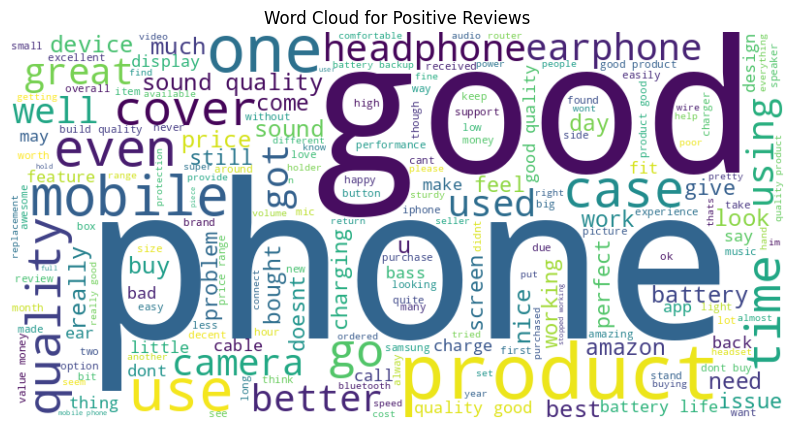

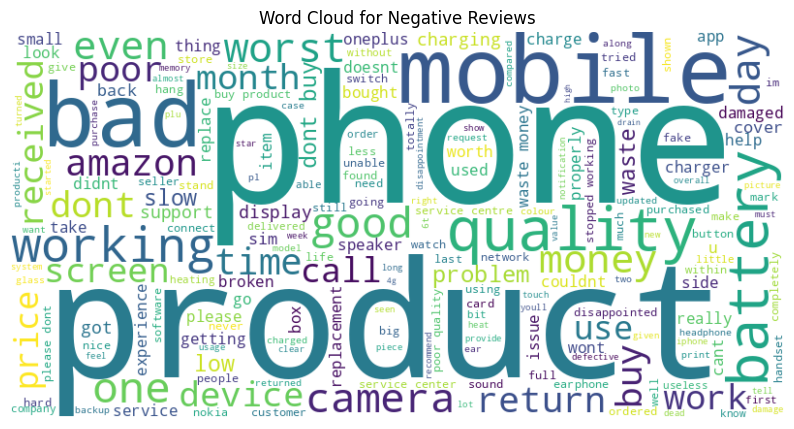

In [ ]:
positive_reviews_text = ' '.join(df[df['sentiment'] == 'Positive']['cust_review'])
negative_reviews_text = ' '.join(df[df['sentiment'] == 'Negative']['cust_review'])

# Word Cloud for Positive Reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud for Negative Reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


In [ ]:
def summarize_product_description(product_description, n_sentences=2):
    if not product_description.strip():
        return []
    sentences = product_description.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence]
    if len(sentences) == 0:
        return []
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    sentence_scores = cosine_sim.sum(axis=1)
    ranked_sentences = [sentences[i] for i in sentence_scores.argsort()[-n_sentences:]]
    return ranked_sentences

df['prod_des_summary'] = df['prod_des'].apply(lambda x: ' '.join(summarize_product_description(x, n_sentences=2)))


In [ ]:
print("\nSummarized Product Descriptions (first 5 products):")
print(df[['prod_des_summary']].head())

print("\nSentiment and POS Tags (first 5 products):")
print(df[['cust_review', 'sentiment', 'pos_tags']].head())


Summarized Product Descriptions (first 5 products):
                                    prod_des_summary
0  samsung galaxy m10 especially created millenni...
1  qualcomm snapdragon 625 20 ghz processor 14nm ...
2  coolpad cool 3 plusdesigned 571 hd dewdrop dis...
3  qualcomm snapdragon 625 20 ghz processor 14nm ...
4  design shaped palm featuring curved ergonomic ...

Sentiment and POS Tags (first 5 products):
                                         cust_review sentiment  \
0  well bit sceptical buying samsung galaxy m10 s...  Positive   
1  display quality top notch overall quality phon...  Positive   
2  low bagget high kwalityits good phone 6000 bad...  Negative   
3  display quality top notch overall quality phon...  Positive   
4  using mobile phone last 3 month smartphone use...  Positive   

                                            pos_tags  
0  [(well, RB), (bit, RB), (sceptical, JJ), (buyi...  
1  [(display, NN), (quality, NN), (top, JJ), (not...  
2  [(low, JJ), (bagget,